# MELD Pipeline (Feature Extraction → Training → Eval)

**Workflow**
1. Install dependencies.
2. Configure paths/models/hyperparameters.
3. Extract features (run once).
4. Train unimodal or multimodal models.
5. Evaluate and plot results.

In [1]:
# Optional: install dependencies on a fresh runtime
%pip install -q torch torchaudio torchvision transformers pandas numpy scikit-learn tqdm opencv-python-headless matplotlib soundfile

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


PROJECT_ROOT = "/content/drive/MyDrive/FinalProject-498K"
PIPE_DIR = f"{PROJECT_ROOT}/mahendra-experiments"

import os
os.environ["MELD_DATASET_ROOT"] = f"{PROJECT_ROOT}/MELD-RAW/MELD.Raw"
os.environ["MELD_FEATURES_ROOT"] = f"{PROJECT_ROOT}/MELD-Features-Models-498K/MELD.Features.Models"


import sys
sys.path.append(PIPE_DIR)

Mounted at /content/drive


In [41]:
import importlib

import meld_pipeline as mp
mp = importlib.reload(mp)

# where is the module coming from?
print("Using meld_pipeline at:", mp.__file__)

Paths = mp.Paths
ModelNames = mp.ModelNames
TrainConfig = mp.TrainConfig
run_feature_extraction = mp.run_feature_extraction
train_unimodal = mp.train_unimodal
train_multimodal = mp.train_multimodal
eval_unimodal_model = mp.eval_unimodal_model
eval_multimodal_model = mp.eval_multimodal_model
plot_f1_bar = mp.plot_f1_bar
plot_confusion = mp.plot_confusion
device = mp.device

# Point dataset_root to the directory that contains MELD-RAW/ (defaults to current project root).
# You can also set the env vars MELD_DATASET_ROOT and MELD_FEATURES_ROOT before starting the kernel.
paths = Paths()
train_cfg = TrainConfig()
model_names = ModelNames()

print(paths)
print(train_cfg)
print(model_names)
print("Using device:", device)


Torch: 2.9.0+cu126
Device: cuda
Label map: {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
Using meld_pipeline at: /content/drive/MyDrive/FinalProject-498K/mahendra-experiments/meld_pipeline.py
Paths(dataset_root=PosixPath('/content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw'), features_root=PosixPath('/content/drive/MyDrive/FinalProject-498K/MELD-Features-Models-498K/MELD.Features.Models'))
TrainConfig(num_classes=7, max_text_len=64, wav_target_sr=16000, num_video_frames=5, batch_size=4, lr=2e-05, num_epochs=3, device='cuda')
ModelNames(text_model='roberta-base', audio_model='facebook/wav2vec2-base-960h', video_model='google/vit-base-patch16-224-in21k')
Using device: cuda


In [21]:
import torch.optim as optim

# Hyperparameters (override defaults from meld_pipeline.py)
# Unimodal
UNI_HIDDEN = 512
UNI_DROPOUT = 0.2
UNI_LR = 5e-5 # learning rate
UNI_WD = 1e-2 # weight decay
UNI_EPOCHS = 15
UNI_OPTIMIZER = optim.AdamW
UNI_OPT_KWARGS = {"lr": UNI_LR, "weight_decay": UNI_WD}

# Multimodal
MM_HIDDEN = 512
MM_HEADS = 4
MM_LAYERS = 2
MM_DROPOUT = 0.2
MM_LR = 5e-5 # learning rate
MM_WD = 1e-2 # weight decay
MM_W_TEXT = 0.5 # weight for text modality
MM_W_AUDIO = 0.3 # weight for audio modality
MM_W_VIDEO = 0.2 # weight for video modality
MM_EPOCHS = 15 # number of epochs
MM_OPTIMIZER = optim.AdamW # optimizer
MM_OPT_KWARGS = {"lr": MM_LR, "weight_decay": MM_WD} # optimizer arguments

# Shared
BATCH_SIZE = 32 # batch size

# Apply batch size to TrainConfig for loaders that use it elsewhere
train_cfg.batch_size = BATCH_SIZE


In [6]:
# 1) Feature extraction (run once; creates features under paths.features_root)
DO_EXTRACT = False  # change to True the first time

if DO_EXTRACT:
    run_feature_extraction(paths=paths, model_names=model_names, train_cfg=train_cfg)


[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/train/train_sent_emo.csv
[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/dev/dev_sent_emo.csv
[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/test/test_sent_emo.csv
Loaded CSVs: 9989 1109 2610
Indexing audio and video files under: /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw
  Found 13847 wav files, 13848 mp4 files
Loading encoders...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Encoders ready.


Extract train:   0%|          | 0/9989 [00:00<?, ?it/s]

Error encoding video /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/dev/dev_splits_complete/dia2_utt2.mp4


Extract dev:   0%|          | 0/1109 [00:00<?, ?it/s]

Extract test:   0%|          | 0/2610 [00:00<?, ?it/s]

Feature extraction completed.


In [22]:
# 2) Train unimodal baselines (text/audio/video)
DO_TRAIN_UNIMODAL = True

if DO_TRAIN_UNIMODAL:
    for modality in ["text", "audio", "video"]:
        train_unimodal(
            modality,
            hidden=UNI_HIDDEN,
            dropout=UNI_DROPOUT,
            lr=UNI_LR,
            weight_decay=UNI_WD,
            num_epochs=UNI_EPOCHS,
            batch_size=BATCH_SIZE,
            optimizer_cls=UNI_OPTIMIZER,
            optimizer_kwargs=UNI_OPT_KWARGS,
        )



=== Unimodal training: text ===
Using class weights: [0.3029724 0.8187034 2.0893118 1.2867448 1.1842324 5.324627  5.2656827]


text Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 1 Train Loss: 1.9298 | Train Acc: 0.2367
[text] Epoch 1 Dev Loss: 1.9017 | Dev F1: 0.2609 | Dev Acc: 0.3120
[text] New best Dev F1=0.2609 → saved unimodal_text_best.pt


text Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 2 Train Loss: 1.8829 | Train Acc: 0.2512
[text] Epoch 2 Dev Loss: 1.8793 | Dev F1: 0.3175 | Dev Acc: 0.3472
[text] New best Dev F1=0.3175 → saved unimodal_text_best.pt


text Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 3 Train Loss: 1.8619 | Train Acc: 0.2835
[text] Epoch 3 Dev Loss: 1.8789 | Dev F1: 0.2409 | Dev Acc: 0.2615


text Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 4 Train Loss: 1.8404 | Train Acc: 0.3225
[text] Epoch 4 Dev Loss: 1.8393 | Dev F1: 0.3013 | Dev Acc: 0.3192


text Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 5 Train Loss: 1.8127 | Train Acc: 0.3620
[text] Epoch 5 Dev Loss: 1.8112 | Dev F1: 0.3260 | Dev Acc: 0.3300
[text] New best Dev F1=0.3260 → saved unimodal_text_best.pt


text Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 6 Train Loss: 1.7753 | Train Acc: 0.4269
[text] Epoch 6 Dev Loss: 1.7751 | Dev F1: 0.4633 | Dev Acc: 0.4626
[text] New best Dev F1=0.4633 → saved unimodal_text_best.pt


text Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 7 Train Loss: 1.7438 | Train Acc: 0.4581
[text] Epoch 7 Dev Loss: 1.7841 | Dev F1: 0.4633 | Dev Acc: 0.5221
[text] New best Dev F1=0.4633 → saved unimodal_text_best.pt


text Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 8 Train Loss: 1.7092 | Train Acc: 0.4989
[text] Epoch 8 Dev Loss: 1.7223 | Dev F1: 0.5010 | Dev Acc: 0.5077
[text] New best Dev F1=0.5010 → saved unimodal_text_best.pt


text Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 9 Train Loss: 1.6880 | Train Acc: 0.5035
[text] Epoch 9 Dev Loss: 1.7119 | Dev F1: 0.4716 | Dev Acc: 0.4500


text Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 10 Train Loss: 1.6573 | Train Acc: 0.5178
[text] Epoch 10 Dev Loss: 1.6724 | Dev F1: 0.5077 | Dev Acc: 0.4986
[text] New best Dev F1=0.5077 → saved unimodal_text_best.pt


text Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 11 Train Loss: 1.6348 | Train Acc: 0.5290
[text] Epoch 11 Dev Loss: 1.6591 | Dev F1: 0.5003 | Dev Acc: 0.4878


text Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 12 Train Loss: 1.6157 | Train Acc: 0.5223
[text] Epoch 12 Dev Loss: 1.6488 | Dev F1: 0.5026 | Dev Acc: 0.4995


text Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 13 Train Loss: 1.5958 | Train Acc: 0.5271
[text] Epoch 13 Dev Loss: 1.6355 | Dev F1: 0.5074 | Dev Acc: 0.4914


text Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 14 Train Loss: 1.5796 | Train Acc: 0.5239
[text] Epoch 14 Dev Loss: 1.6247 | Dev F1: 0.5091 | Dev Acc: 0.5032
[text] New best Dev F1=0.5091 → saved unimodal_text_best.pt


text Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

[text] Epoch 15 Train Loss: 1.5663 | Train Acc: 0.5229
[text] Epoch 15 Dev Loss: 1.6480 | Dev F1: 0.5085 | Dev Acc: 0.5041
Finished text training. Best Dev F1=0.5091 (saved at unimodal_text_best.pt)

=== Unimodal training: audio ===
Using class weights: [0.3029724 0.8187034 2.0893118 1.2867448 1.1842324 5.324627  5.2656827]


audio Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 1 Train Loss: 1.9425 | Train Acc: 0.2000
[audio] Epoch 1 Dev Loss: 1.9144 | Dev F1: 0.1915 | Dev Acc: 0.2083
[audio] New best Dev F1=0.1915 → saved unimodal_audio_best.pt


audio Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 2 Train Loss: 1.9345 | Train Acc: 0.2073
[audio] Epoch 2 Dev Loss: 1.9100 | Dev F1: 0.1598 | Dev Acc: 0.1849


audio Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 3 Train Loss: 1.9258 | Train Acc: 0.1912
[audio] Epoch 3 Dev Loss: 1.9139 | Dev F1: 0.1194 | Dev Acc: 0.1596


audio Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 4 Train Loss: 1.9231 | Train Acc: 0.1951
[audio] Epoch 4 Dev Loss: 1.9051 | Dev F1: 0.2081 | Dev Acc: 0.2110
[audio] New best Dev F1=0.2081 → saved unimodal_audio_best.pt


audio Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 5 Train Loss: 1.9175 | Train Acc: 0.1950
[audio] Epoch 5 Dev Loss: 1.8984 | Dev F1: 0.2215 | Dev Acc: 0.2218
[audio] New best Dev F1=0.2215 → saved unimodal_audio_best.pt


audio Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 6 Train Loss: 1.9080 | Train Acc: 0.1990
[audio] Epoch 6 Dev Loss: 1.9058 | Dev F1: 0.2218 | Dev Acc: 0.2155
[audio] New best Dev F1=0.2218 → saved unimodal_audio_best.pt


audio Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 7 Train Loss: 1.9091 | Train Acc: 0.1987
[audio] Epoch 7 Dev Loss: 1.8863 | Dev F1: 0.2248 | Dev Acc: 0.2137
[audio] New best Dev F1=0.2248 → saved unimodal_audio_best.pt


audio Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 8 Train Loss: 1.9049 | Train Acc: 0.1950
[audio] Epoch 8 Dev Loss: 1.9003 | Dev F1: 0.1662 | Dev Acc: 0.1993


audio Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 9 Train Loss: 1.8975 | Train Acc: 0.2120
[audio] Epoch 9 Dev Loss: 1.8826 | Dev F1: 0.1790 | Dev Acc: 0.1984


audio Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 10 Train Loss: 1.8928 | Train Acc: 0.2238
[audio] Epoch 10 Dev Loss: 1.9063 | Dev F1: 0.2062 | Dev Acc: 0.1993


audio Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 11 Train Loss: 1.8911 | Train Acc: 0.2134
[audio] Epoch 11 Dev Loss: 1.8943 | Dev F1: 0.2631 | Dev Acc: 0.2552
[audio] New best Dev F1=0.2631 → saved unimodal_audio_best.pt


audio Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 12 Train Loss: 1.8884 | Train Acc: 0.2112
[audio] Epoch 12 Dev Loss: 1.8827 | Dev F1: 0.2208 | Dev Acc: 0.2182


audio Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 13 Train Loss: 1.8854 | Train Acc: 0.2199
[audio] Epoch 13 Dev Loss: 1.8864 | Dev F1: 0.2509 | Dev Acc: 0.2408


audio Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 14 Train Loss: 1.8802 | Train Acc: 0.2221
[audio] Epoch 14 Dev Loss: 1.8750 | Dev F1: 0.2498 | Dev Acc: 0.2372


audio Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

[audio] Epoch 15 Train Loss: 1.8780 | Train Acc: 0.2023
[audio] Epoch 15 Dev Loss: 1.8648 | Dev F1: 0.2100 | Dev Acc: 0.2191
Finished audio training. Best Dev F1=0.2631 (saved at unimodal_audio_best.pt)

=== Unimodal training: video ===
Using class weights: [0.3029724 0.8187034 2.0893118 1.2867448 1.1842324 5.324627  5.2656827]


video Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 1 Train Loss: 1.9464 | Train Acc: 0.2032
[video] Epoch 1 Dev Loss: 1.9314 | Dev F1: 0.1547 | Dev Acc: 0.1686
[video] New best Dev F1=0.1547 → saved unimodal_video_best.pt


video Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 2 Train Loss: 1.9160 | Train Acc: 0.2131
[video] Epoch 2 Dev Loss: 1.9337 | Dev F1: 0.1955 | Dev Acc: 0.1758
[video] New best Dev F1=0.1955 → saved unimodal_video_best.pt


video Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 3 Train Loss: 1.8869 | Train Acc: 0.2327
[video] Epoch 3 Dev Loss: 1.9263 | Dev F1: 0.1657 | Dev Acc: 0.1713


video Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 4 Train Loss: 1.8492 | Train Acc: 0.2267
[video] Epoch 4 Dev Loss: 1.9251 | Dev F1: 0.1386 | Dev Acc: 0.1551


video Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 5 Train Loss: 1.8052 | Train Acc: 0.2310
[video] Epoch 5 Dev Loss: 1.9358 | Dev F1: 0.1239 | Dev Acc: 0.1398


video Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 6 Train Loss: 1.7566 | Train Acc: 0.2369
[video] Epoch 6 Dev Loss: 1.9444 | Dev F1: 0.1555 | Dev Acc: 0.1470


video Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 7 Train Loss: 1.6970 | Train Acc: 0.2530
[video] Epoch 7 Dev Loss: 1.9763 | Dev F1: 0.1376 | Dev Acc: 0.1380


video Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 8 Train Loss: 1.6416 | Train Acc: 0.2604
[video] Epoch 8 Dev Loss: 1.9878 | Dev F1: 0.1418 | Dev Acc: 0.1533


video Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 9 Train Loss: 1.5856 | Train Acc: 0.2863
[video] Epoch 9 Dev Loss: 2.0578 | Dev F1: 0.1340 | Dev Acc: 0.1253


video Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 10 Train Loss: 1.5225 | Train Acc: 0.2977
[video] Epoch 10 Dev Loss: 2.0309 | Dev F1: 0.1291 | Dev Acc: 0.1425


video Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 11 Train Loss: 1.4699 | Train Acc: 0.3065
[video] Epoch 11 Dev Loss: 2.0797 | Dev F1: 0.1683 | Dev Acc: 0.1650


video Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 12 Train Loss: 1.4023 | Train Acc: 0.3269
[video] Epoch 12 Dev Loss: 2.1320 | Dev F1: 0.1742 | Dev Acc: 0.1605


video Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 13 Train Loss: 1.3586 | Train Acc: 0.3354
[video] Epoch 13 Dev Loss: 2.2028 | Dev F1: 0.1703 | Dev Acc: 0.1659


video Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 14 Train Loss: 1.2978 | Train Acc: 0.3526
[video] Epoch 14 Dev Loss: 2.2380 | Dev F1: 0.1741 | Dev Acc: 0.1668


video Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

[video] Epoch 15 Train Loss: 1.2338 | Train Acc: 0.3717
[video] Epoch 15 Dev Loss: 2.2844 | Dev F1: 0.1538 | Dev Acc: 0.1524
Finished video training. Best Dev F1=0.1955 (saved at unimodal_video_best.pt)


In [25]:
# 3) Train multimodal models
DO_TRAIN_MM_EARLY = True

if DO_TRAIN_MM_EARLY:
    train_multimodal(
        "early",
        hidden_dim=MM_HIDDEN,
        num_heads=MM_HEADS,
        num_layers=MM_LAYERS,
        dropout=MM_DROPOUT,
        lr=MM_LR,
        weight_decay=MM_WD,
        num_epochs=MM_EPOCHS,
        batch_size=BATCH_SIZE,
        optimizer_cls=MM_OPTIMIZER,
        optimizer_kwargs=MM_OPT_KWARGS,
    )



=== Multimodal training (early fusion) ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.5786 | Train Acc=0.4614 | Dev F1=0.2526 | Dev Acc=0.4238
[early] New best Dev F1=0.2526 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.4885 | Train Acc=0.4759 | Dev F1=0.3491 | Dev Acc=0.4364
[early] New best Dev F1=0.3491 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.4453 | Train Acc=0.4878 | Dev F1=0.3411 | Dev Acc=0.4626


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.3797 | Train Acc=0.5243 | Dev F1=0.3676 | Dev Acc=0.4779
[early] New best Dev F1=0.3676 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Train Loss=1.3156 | Train Acc=0.5492 | Dev F1=0.4315 | Dev Acc=0.5149
[early] New best Dev F1=0.4315 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: Train Loss=1.2547 | Train Acc=0.5686 | Dev F1=0.4707 | Dev Acc=0.5347
[early] New best Dev F1=0.4707 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: Train Loss=1.1944 | Train Acc=0.5895 | Dev F1=0.4753 | Dev Acc=0.4977
[early] New best Dev F1=0.4753 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: Train Loss=1.1388 | Train Acc=0.6099 | Dev F1=0.4688 | Dev Acc=0.5383


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: Train Loss=1.0935 | Train Acc=0.6205 | Dev F1=0.4860 | Dev Acc=0.5329
[early] New best Dev F1=0.4860 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Train Loss=1.0422 | Train Acc=0.6400 | Dev F1=0.4905 | Dev Acc=0.5455
[early] New best Dev F1=0.4905 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.9941 | Train Acc=0.6589 | Dev F1=0.4912 | Dev Acc=0.5446
[early] New best Dev F1=0.4912 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.9458 | Train Acc=0.6749 | Dev F1=0.5146 | Dev Acc=0.5518
[early] New best Dev F1=0.5146 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.8960 | Train Acc=0.6912 | Dev F1=0.5221 | Dev Acc=0.5582
[early] New best Dev F1=0.5221 → saved multimodal_early_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.8516 | Train Acc=0.7133 | Dev F1=0.5091 | Dev Acc=0.5573


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.8073 | Train Acc=0.7259 | Dev F1=0.5057 | Dev Acc=0.5537
Finished multimodal early training. Best Dev F1=0.5221 (saved at multimodal_early_fusion_best.pt)


In [26]:
DO_TRAIN_MM_LATE = True

if DO_TRAIN_MM_LATE:
    train_multimodal(
        "late",
        hidden_dim=MM_HIDDEN,
        num_heads=MM_HEADS,
        num_layers=MM_LAYERS,
        dropout=MM_DROPOUT,
        lr=MM_LR,
        weight_decay=MM_WD,
        num_epochs=MM_EPOCHS,
        batch_size=BATCH_SIZE,
        w_text=MM_W_TEXT,
        w_audio=MM_W_AUDIO,
        w_video=MM_W_VIDEO,
        learnable_weights=True,
        optimizer_cls=MM_OPTIMIZER,
        optimizer_kwargs=MM_OPT_KWARGS,
    )


=== Multimodal training (late fusion) ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.5734 | Train Acc=0.4595 | Dev F1=0.2523 | Dev Acc=0.4238
[late] New best Dev F1=0.2523 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.5116 | Train Acc=0.4719 | Dev F1=0.2519 | Dev Acc=0.4229


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.4568 | Train Acc=0.4754 | Dev F1=0.2914 | Dev Acc=0.4328
[late] New best Dev F1=0.2914 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.4297 | Train Acc=0.4851 | Dev F1=0.3505 | Dev Acc=0.4707
[late] New best Dev F1=0.3505 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Train Loss=1.3841 | Train Acc=0.5094 | Dev F1=0.3402 | Dev Acc=0.4626


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: Train Loss=1.3202 | Train Acc=0.5370 | Dev F1=0.4293 | Dev Acc=0.5176
[late] New best Dev F1=0.4293 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: Train Loss=1.2650 | Train Acc=0.5573 | Dev F1=0.4221 | Dev Acc=0.5185


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: Train Loss=1.2297 | Train Acc=0.5728 | Dev F1=0.4162 | Dev Acc=0.5086


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: Train Loss=1.2075 | Train Acc=0.5696 | Dev F1=0.4565 | Dev Acc=0.5329
[late] New best Dev F1=0.4565 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Train Loss=1.1500 | Train Acc=0.5929 | Dev F1=0.4832 | Dev Acc=0.5528
[late] New best Dev F1=0.4832 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: Train Loss=1.1256 | Train Acc=0.5948 | Dev F1=0.4879 | Dev Acc=0.5518
[late] New best Dev F1=0.4879 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: Train Loss=1.0970 | Train Acc=0.5995 | Dev F1=0.4991 | Dev Acc=0.5582
[late] New best Dev F1=0.4991 → saved multimodal_late_fusion_best.pt


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: Train Loss=1.0722 | Train Acc=0.6077 | Dev F1=0.4590 | Dev Acc=0.5392


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: Train Loss=1.0344 | Train Acc=0.6165 | Dev F1=0.4970 | Dev Acc=0.5636


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Train Loss=1.0129 | Train Acc=0.6153 | Dev F1=0.4757 | Dev Acc=0.5437
Finished multimodal late training. Best Dev F1=0.4991 (saved at multimodal_late_fusion_best.pt)


Unimodal text (test) F1: 0.5642, Acc: 0.5510
Unimodal audio (test) F1: 0.2723, Acc: 0.2498
Unimodal video (test) F1: 0.2248, Acc: 0.1854
Multimodal early-fusion (test) F1: 0.5286, Acc: 0.5632
Multimodal late-fusion (test) F1: 0.5418, Acc: 0.5931


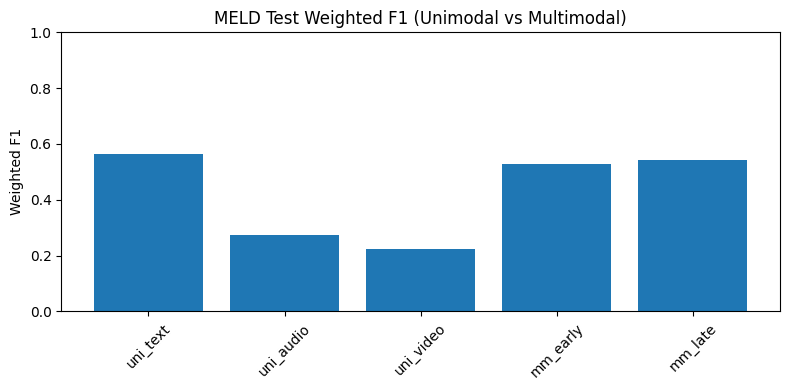

<Figure size 600x600 with 0 Axes>

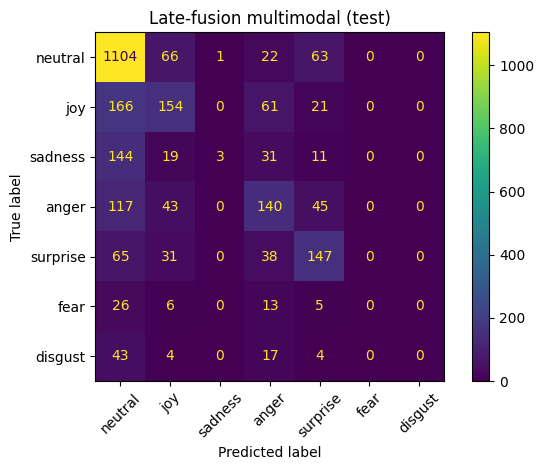

In [43]:
# 4) Evaluate saved models and plot results
DO_PLOT_EVAL = True
EVAL_SPLIT = "test"  # change to "dev" for dev numbers

if DO_PLOT_EVAL:
    results = {}

    # Unimodal models
    try:
        f1_t, acc_t, lab_t, pred_t = eval_unimodal_model(
            "text", f"{PROJECT_ROOT}/ckpts/unimodal_text_best.pt", split=EVAL_SPLIT
        )
        results["uni_text"] = f1_t
        print(f"Unimodal text ({EVAL_SPLIT}) F1: {f1_t:.4f}, Acc: {acc_t:.4f}")
    except FileNotFoundError as e:
        print("Text model missing:", e)

    try:
        f1_a, acc_a, lab_a, pred_a = eval_unimodal_model(
            "audio", f"{PROJECT_ROOT}/ckpts/unimodal_audio_best.pt", split=EVAL_SPLIT
        )
        results["uni_audio"] = f1_a
        print(f"Unimodal audio ({EVAL_SPLIT}) F1: {f1_a:.4f}, Acc: {acc_a:.4f}")
    except FileNotFoundError as e:
        print("Audio model missing:", e)

    try:
        f1_v, acc_v, lab_v, pred_v = eval_unimodal_model(
            "video", f"{PROJECT_ROOT}/ckpts/unimodal_video_best.pt", split=EVAL_SPLIT
        )
        results["uni_video"] = f1_v
        print(f"Unimodal video ({EVAL_SPLIT}) F1: {f1_v:.4f}, Acc: {acc_v:.4f}")
    except FileNotFoundError as e:
        print("Video model missing:", e)

    # Multimodal models (set hyperparams to match training)
    try:
        f1_early, acc_early, lab_early, pred_early = eval_multimodal_model(
            "early",
            f"{PROJECT_ROOT}/ckpts/multimodal_early_fusion_best.pt",
            split=EVAL_SPLIT,
            hidden_dim=512,
            num_heads=4,
            num_layers=2,
            dropout=0.2,
        )
        results["mm_early"] = f1_early
        print(f"Multimodal early-fusion ({EVAL_SPLIT}) F1: {f1_early:.4f}, Acc: {acc_early:.4f}")
    except FileNotFoundError as e:
        print("Early-fusion model missing:", e)

    try:
        f1_late, acc_late, lab_late, pred_late = eval_multimodal_model(
            "late",
            f"{PROJECT_ROOT}/ckpts/multimodal_late_fusion_best.pt",
            split=EVAL_SPLIT,
            hidden_dim=512,
            num_heads=4,
            num_layers=2,
            dropout=0.2,
        )
        results["mm_late"] = f1_late
        print(f"Multimodal late-fusion ({EVAL_SPLIT}) F1: {f1_late:.4f}, Acc: {acc_late:.4f}")
    except FileNotFoundError as e:
        print("Late-fusion model missing:", e)

    if results:
      plot_f1_bar(results, f"MELD {EVAL_SPLIT.title()} Weighted F1 (Unimodal vs Multimodal)")
      if "mm_late" in results:
          plot_confusion(lab_late, pred_late, f"Late-fusion multimodal ({EVAL_SPLIT})")
      elif "mm_early" in results:
          plot_confusion(lab_early, pred_early, f"Early-fusion multimodal ({EVAL_SPLIT})")
      elif "uni_text" in results:
          plot_confusion(lab_t, pred_t, f"Unimodal text ({EVAL_SPLIT})")

In [44]:
import pandas as pd
from collections import Counter
import meld_pipeline as mp

splits = ["train", "dev", "test"]
for split in splits:
    csv_path = mp.find_meld_csv(mp.paths.dataset_root, split)
    df = pd.read_csv(csv_path)
    labels = df["Emotion"].str.lower()
    counts = labels.value_counts()
    ordered = [counts.get(lbl, 0) for lbl in mp.EMOTIONS]
    print(f"\n{split.upper()} size: {len(df)}")
    for lbl, cnt in zip(mp.EMOTIONS, ordered):
        print(f"  {lbl:9s}: {cnt}")

[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/train/train_sent_emo.csv

TRAIN size: 9989
  neutral  : 4710
  joy      : 1743
  sadness  : 683
  anger    : 1109
  surprise : 1205
  fear     : 268
  disgust  : 271
[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/dev/dev_sent_emo.csv

DEV size: 1109
  neutral  : 470
  joy      : 163
  sadness  : 111
  anger    : 153
  surprise : 150
  fear     : 40
  disgust  : 22
[find_meld_csv] Using (rglob): /content/drive/MyDrive/FinalProject-498K/MELD-RAW/MELD.Raw/test/test_sent_emo.csv

TEST size: 2610
  neutral  : 1256
  joy      : 402
  sadness  : 208
  anger    : 345
  surprise : 281
  fear     : 50
  disgust  : 68
